In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io as sio
import glob


In [2]:
only_mouse = False
def load_and_process_data(directory_path, part_of_file_name):
    # get latest file from data folder that includes part_of_file_name in its name
    fileIs = sorted((f for f in glob.glob(f"{directory_path}/*") if part_of_file_name in f), key=os.path.getctime)[-1]

    # load the .mat file
    mat_contents = sio.loadmat(fileIs)
    # extract the necessary data
    if only_mouse:
        sigma, target = mat_contents['sigma'], mat_contents['blob_x']
    else:
        sigma, eyeResp, target = mat_contents['sigma'], mat_contents['eyeX'], mat_contents['blob_x']

    mouseResp = mat_contents['mouse_x'] if fileIs.split('_')[2] == "both" else None
    if mouseResp is not None:
        mouseResp = mouseResp - np.mean(mouseResp, axis=1, keepdims=True)
    eyeResp = eyeResp - np.mean(eyeResp, axis=1, keepdims=True)
    target = target - np.mean(target, axis=1, keepdims=True)
   
    # calculate the number of trials
    nTrial = len(sigma.flatten())
    nSigma = (nTrial - 1) // 5 + 1
    nTrialPerSigma = nTrial // nSigma
    blob_widths = np.unique(sigma.flatten())

    return sigma,eyeResp, target, mouseResp, nTrial, nSigma, nTrialPerSigma, blob_widths


sigma, eyeResp, target, mouseResp = load_and_process_data("data_both", "p8")[:4]
blob_widths = np.unique(sigma.flatten())
# calculate the number of trials
nTrial = len(sigma.flatten())
nSigma = (nTrial - 1) // 5 + 1
nTrialPerSigma = nTrial // nSigma

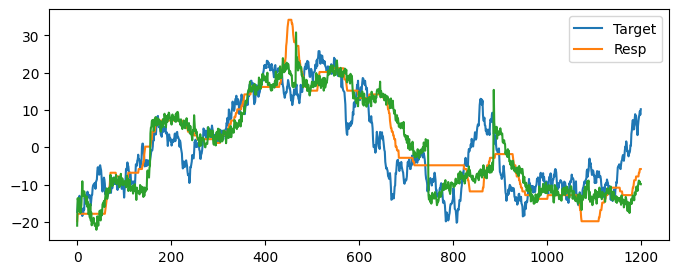

In [8]:
# plot the data
sigma, eyeResp, target, mouseResp = load_and_process_data("data_both", "p8")[:4]

trialNum=2
plt.figure(figsize=(8,3))
plt.plot(target[trialNum,:])
plt.plot(mouseResp[trialNum,:])
plt.plot(eyeResp[trialNum,:])
plt.legend(['Target','Resp'])
plt.show()



In [5]:
from scipy.ndimage import gaussian_filter1d

def smooth_data(data_to_smooth, window_size=10):
    # Create a moving average filter
    filter = np.ones(window_size) / window_size
    # Apply the filter to the response data using list comprehension
    smoothed_response = [np.convolve(trial, filter, mode='same') for trial in data_to_smooth]
    return np.squeeze(smoothed_response)
eyeResp = smooth_data(eyeResp)
#target = smooth_data(target)

In [6]:
response=eyeResp
# create key-value pairs for the dictionary of 30 trials
trial_dict = {}
for i in range(nTrial):
    trial_dict[i]={'target': target[i,60:], 'eyeResp': eyeResp[i,60:], 'sigma': sigma[0][i]} #my data
    if fileIs.split('_')[1]=="both":
        trial_dict[i]['mouseResp']=mouseResp[i,60:]

# sort the dictionary by sigma
trialDictSorted = sorted(((k, v) for k, v in trial_dict.items()), key=lambda x: x[1]['sigma']) # x[1]['sigma'] gives the value of sigma for each trial and la
tmp_trial=trialDictSorted[0][1]

## Negative Log Likelihood Uncertainty Estimates

In [7]:
from scipy.sparse import diags
import scipy.optimize as opt
def negLogLikelihood(rr, Q, X, Xhat):
    numTrials = X.shape[1]  # number of trials
    N = X.shape[0]          # number of samples

    rr = np.exp(rr)  # exponentiate observation noise variance
    pp = Q / 2 * (np.sqrt(1 + 4 * rr / Q) - 1)  # posterior variance - Eq B8
    k = (pp + Q) / (pp + Q + rr)  # Kalman Gain - eq B10
    
    # Create a sparse matrix for D
    d = diags([np.ones(N), (k - 1) * np.ones(N)], [0, -1], shape=(N, N)).toarray()  # Eq B12

    # Compute nLL using list comprehension
    nLL = -sum(-1 / (2 * k**2 * rr) * np.dot((np.dot(d, Xhat[:, i]) - k * X[:, i]).T, np.dot(d, Xhat[:, i]) - k * X[:, i]) - N / 2 * np.log(rr) - N * np.log(k) for i in range(numTrials))

    return nLL
from scipy.optimize import minimize



In [8]:
import matplotlib.cm as cm
import numpy as np
# Get the 'viridis' colormap
cmap = cm.get_cmap('rainbow')
# Generate 10 evenly spaced values between 0 and 1
values = np.linspace(0, 1, 10)
# Get 10 colors from the colormap
colors = [cmap(value) for value in values]
colors = ['#000000', '#800000', '#008000', '#000080', '#808000', '#800080', '#008080', '#606060', '#804000', '#408080']

C:\Users\omeru\AppData\Local\Temp\ipykernel_36988\2667010660.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')


0
Optimal value for observation noise variance is 2.699864530550444
Optimal value for observation noise variance is 2.447987098840816
Optimal value for observation noise variance is 2.4843377571258634
0


C:\Users\omeru\AppData\Local\Temp\ipykernel_36988\1517604384.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.7557772189831686
Optimal value for observation noise variance is 2.505789263268448
Optimal value for observation noise variance is 2.335855746572428
1


C:\Users\omeru\AppData\Local\Temp\ipykernel_36988\1517604384.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.8559205568720833
Optimal value for observation noise variance is 2.8101593295329574
Optimal value for observation noise variance is 2.842619795702926
1
Optimal value for observation noise variance is 2.749641439455426
Optimal value for observation noise variance is 2.4838223076580115
Optimal value for observation noise variance is 2.3480299191195897
2


C:\Users\omeru\AppData\Local\Temp\ipykernel_36988\1517604384.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 3.2775426811443125
Optimal value for observation noise variance is 2.6343072952600393
Optimal value for observation noise variance is 2.711752840577112
2
Optimal value for observation noise variance is 2.8955386785654182
Optimal value for observation noise variance is 2.399357960915463
Optimal value for observation noise variance is 2.3918390797900924
3


C:\Users\omeru\AppData\Local\Temp\ipykernel_36988\1517604384.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 3.722277633264957
Optimal value for observation noise variance is 3.5171384830963355
Optimal value for observation noise variance is 3.298046337325964
3


C:\Users\omeru\AppData\Local\Temp\ipykernel_36988\1517604384.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.717464417478744
Optimal value for observation noise variance is 2.429434592115307
Optimal value for observation noise variance is 2.412064097495294
4


C:\Users\omeru\AppData\Local\Temp\ipykernel_36988\1517604384.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.9488091511123606
Optimal value for observation noise variance is 2.7436795310011464
Optimal value for observation noise variance is 2.569805522765863
4
Optimal value for observation noise variance is 2.762364736713618
Optimal value for observation noise variance is 2.574392257233393
Optimal value for observation noise variance is 2.3524727886756436
5
Optimal value for observation noise variance is 3.213971937877959
Optimal value for observation noise variance is 2.7305128884142187
Optimal value for observation noise variance is 3.001053144696728
5
Optimal value for observation noise variance is 2.7401062054549605
Optimal value for observation noise variance is 2.9388093824778014
Optimal value for observation noise variance is 2.355947425028202
6


C:\Users\omeru\AppData\Local\Temp\ipykernel_36988\1517604384.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.803536485092261
Optimal value for observation noise variance is 2.5853500681491703
Optimal value for observation noise variance is 2.595438510620473
6
Optimal value for observation noise variance is 2.6115728606039372
Optimal value for observation noise variance is 2.3674821411740545
Optimal value for observation noise variance is 2.379488782948496
7


C:\Users\omeru\AppData\Local\Temp\ipykernel_36988\1517604384.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.87199552955316
Optimal value for observation noise variance is 2.6609883437439805
Optimal value for observation noise variance is 2.7120204075176892
7
Optimal value for observation noise variance is 2.823706505709059
Optimal value for observation noise variance is 3.0554521424645955
Optimal value for observation noise variance is 2.3031143255626265
8


C:\Users\omeru\AppData\Local\Temp\ipykernel_36988\1517604384.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.868270581789099
Optimal value for observation noise variance is 2.8419679093759376
Optimal value for observation noise variance is 2.572170723989844
8
Optimal value for observation noise variance is 2.6823984646676466
Optimal value for observation noise variance is 2.486959970581023
Optimal value for observation noise variance is 2.373996033430893
9
Optimal value for observation noise variance is 2.754519410272096


C:\Users\omeru\AppData\Local\Temp\ipykernel_36988\1517604384.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 3.33592920408804
Optimal value for observation noise variance is 3.022269857044536
9
Optimal value for observation noise variance is 2.6990440974236027
Optimal value for observation noise variance is 2.5600778659300425
Optimal value for observation noise variance is 2.464070673720085


C:\Users\omeru\AppData\Local\Temp\ipykernel_36988\1517604384.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Text(0, 0.5, 'Positional Uncertainty (sqrt(R))')

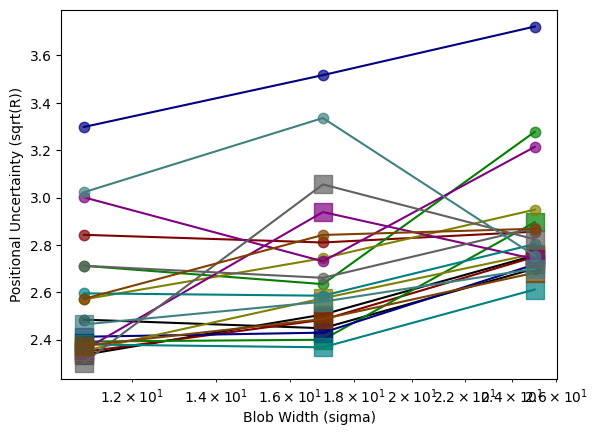

In [24]:
rValBoth_all = []
rValEye_all = []
for numP in range(10):
    randomColorCode = np.random.rand(3,)
    for dataType in ["data_eye", "data_both"]:
        r_values_eye = []
        r_values_both = []
        sigma, eyeResp, target, mouseResp = load_and_process_data(dataType, 'p'+str(numP))[:4]
        print(numP)
        X = target
        if dataType == "data_both":
            Y = mouseResp
        else:
            Y = eyeResp
            #Y = smooth_data(Y)
        nLLs = []
        i=0
        # Initialize arrays to store results
        r_values = np.zeros(len(blob_widths))
        fval_values = np.zeros(len(blob_widths))
        # Plot setup
        lag=12
        clip=60

        Xc = X[:, clip:X.shape[1] -lag] - np.mean(X[:, clip:X.shape[1]-lag], axis=1)[:, np.newaxis]
        Yc = Y[:, lag+clip:] - np.mean(Y[:, lag+clip:], axis=1)[:, np.newaxis]
        results=[]
        Q=1
        # calculate intirial Guess for Q 
        rr_initial_guess = np.log(100)  # Initial guess for log observation noise variance
        # sigmas is reversed unique values of sigma
        sigmas = np.unique(sigma)[::-1]
        for i in range(len(sigmas)):
            index = [s == sigmas[i] for s in sigma]
            index=np.array(index).flatten()
            #calculate Q for each sigma as a variance of displacement
            result = minimize(negLogLikelihood, rr_initial_guess, args=(Q, Xc[index,:].T, Yc[index,:].T), method='BFGS', options={'maxiter': 1000})
            results.append(result)
            # # Store optimization results
            r_values[i] = np.sqrt(result.x[0])
            fval_values[i] = result.fun
            print('Optimal value for observation noise variance is ' + str(r_values[i]))
            # # Plot the result
            if dataType=="data_both":    
                plt.semilogx(sigmas[i], r_values[i], 's', linewidth=3, markersize=13, label=f'sigma={sigmas}',color=colors[numP], alpha=0.7)
                #r_values_both.append(r_values)

            else:
                plt.semilogx(sigmas[i], r_values[i], '.', linewidth=3, markersize=15, label=f'sigma={sigmas}',color=colors[numP], alpha=0.7)
                #r_values_eye.append(r_values)
        plt.plot(sigmas, r_values, 'k-',color=colors[numP])
        if dataType=="data_both":
            rValBoth_all.append(r_values)
        else:
            rValEye_all.append(r_values)

plt.xlabel('Blob Width (sigma)')
plt.ylabel('Positional Uncertainty (sqrt(R))')

In [10]:
flattned_rValBoth_all = [item for sublist in rValBoth_all for item in sublist]
flattned_rValEye_all = [item for sublist in rValEye_all for item in sublist]

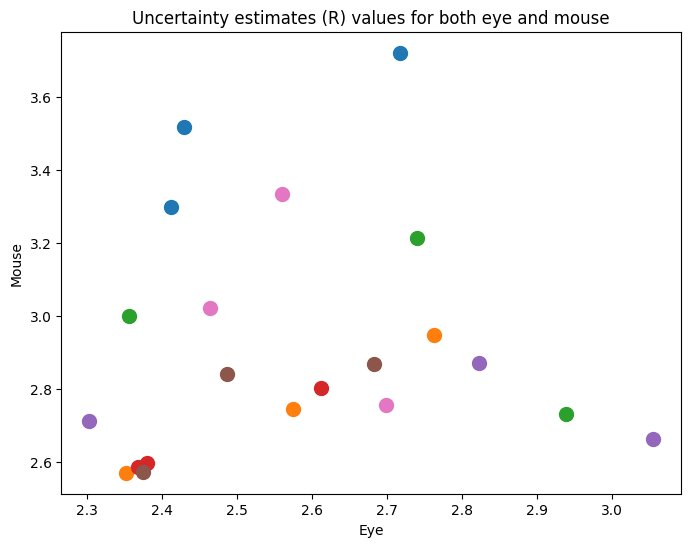

In [12]:
rValBoth_all = np.array(rValBoth_all)
rValEye_all = np.array(rValEye_all)
# Plot R values for both eye and mouse
plt.figure(figsize=(8, 6))
plt.plot(rValBoth_all.T,rValEye_all.T, 'o', markersize=10)
plt.xlabel('Eye')
plt.ylabel('Mouse')
plt.title('Uncertainty estimates (R) values for both eye and mouse')
plt.show()


In [2]:
import numpy as np

# Define the matrix with NaN where indicated
matrix = np.array([
    [10, np.nan, 12,np.nan,np.nan,np.nan],
    [np.nan, 11, np.nan,np.nan,np.nan,15],
])

# Compute the average of each column, ignoring NaN values
average = np.nanmean(matrix, axis=0)
average


C:\Users\omeru\AppData\Local\Temp\ipykernel_12016\366569788.py:10: RuntimeWarning: Mean of empty slice
  average = np.nanmean(matrix, axis=0)


array([10., 11., 12., nan, nan, 15.])

In [41]:
# Create a sample 90x3 matrix filled with random numbers for demonstration
np.random.seed(0)  # Seed for reproducibility
12
large_matrix = np.random.rand(90, 12) * 100  # 90 rows and 3 columns with values scaled to 0-100

# Set half of the values to NaN to simulate missing data
large_matrix[large_matrix > 50] = np.nan
large_matrix[2,0]=10000
print(large_matrix)

[[           nan            nan            nan ... 3.83441519e+01
             nan            nan]
 [           nan            nan 7.10360582e+00 ...            nan
  4.61479362e+01            nan]
 [1.00000000e+04            nan 1.43353287e+01 ...            nan
  1.87898004e+00            nan]
 ...
 [2.42727046e+00 4.30115984e+01            nan ... 2.56113795e+01
             nan 2.32772672e+01]
 [3.10629218e+01            nan            nan ... 8.32909797e+00
  5.10754802e+00            nan]
 [           nan 1.52027227e+01 6.64218590e-02 ...            nan
             nan            nan]]


In [42]:

# Reshape the matrix to group every three rows (now 30x3x3)
reshaped_matrix = large_matrix.reshape(30, 3, 12)
print(reshaped_matrix)


[[[           nan            nan            nan ... 3.83441519e+01
              nan            nan]
  [           nan            nan 7.10360582e+00 ...            nan
   4.61479362e+01            nan]
  [1.00000000e+04            nan 1.43353287e+01 ...            nan
   1.87898004e+00            nan]]

 [[           nan            nan            nan ...            nan
   2.10382561e+01 1.28926298e+01]
  [3.15428351e+01 3.63710771e+01            nan ... 2.53291603e+01
   4.66310773e+01 2.44425592e+01]
  [1.58969584e+01 1.10375141e+01            nan ... 9.60984079e+00
              nan 4.68651202e+01]]

 [[           nan            nan            nan ... 4.14262995e+01
   6.41474963e+00            nan]
  [           nan 2.65389491e+01            nan ...            nan
   2.89406093e+01 1.83191362e+01]
  [           nan 2.01075462e+00            nan ...            nan
              nan            nan]]

 ...

 [[           nan            nan            nan ...            nan
            

In [43]:

# Compute the mean across the new middle axis (axis=1), which corresponds to the three grouped rows
means = np.nanmean(reshaped_matrix, axis=1)
means.shape, means  # Show shape to confirm and some of the resulting means


C:\Users\omeru\AppData\Local\Temp\ipykernel_12016\3370016712.py:2: RuntimeWarning: Mean of empty slice
  means = np.nanmean(reshaped_matrix, axis=1)


((30, 12),
 array([[1.00000000e+04,            nan, 1.07194673e+01, 8.71292997e+00,
         2.21936598e+01, 4.14661940e+01, 3.51071412e+01,            nan,
         4.56150332e+01, 3.83441519e+01, 2.40134581e+01,            nan],
        [2.37198967e+01, 2.37042956e+01,            nan, 2.88392232e+01,
         2.78045131e+01, 3.02600645e+01, 2.08876756e+01, 1.06212088e+01,
                    nan, 1.74695005e+01, 3.38346667e+01, 2.80667697e+01],
        [           nan, 1.42748519e+01,            nan, 4.59412597e+00,
         2.82806963e+01, 1.95102267e+01, 3.07354575e+01, 1.18727719e+01,
         2.32844728e+01, 4.14262995e+01, 1.76776795e+01, 1.83191362e+01],
        [1.79277848e+01, 2.98282326e+01, 4.47125379e+01,            nan,
         4.23855049e+01, 2.97436951e+01, 1.91931983e+00, 3.76499664e+01,
                    nan, 3.28819739e+01, 4.35864925e+01, 4.28768701e+01],
        [           nan, 1.71629677e+01, 2.53705092e+01, 6.17524919e+00,
         1.99996525e+01, 2.36032239e

0.0006944444444444445


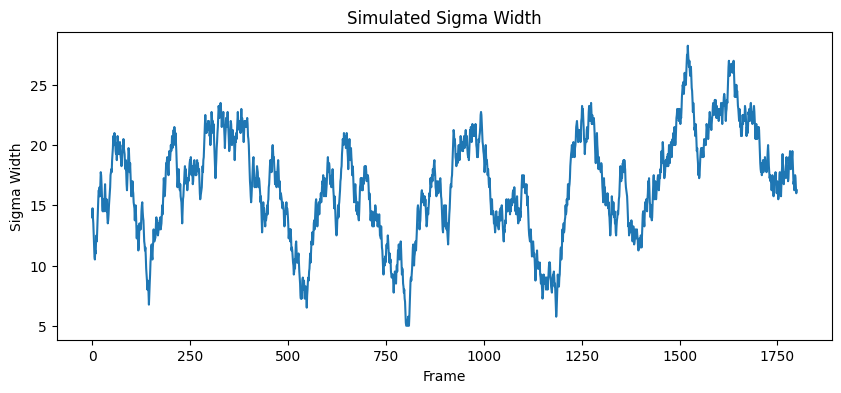

In [250]:
expectedFrameRate=60
toleranceTrialN=600

from matplotlib import pyplot as plt

def generateWalkofSigmaDifficulty(meanSigma=15, velocity_std=1, duration=20,minSigma=10,maxSigma=30):
    # Generate random velocity for each fram
    num_frames = int(duration * expectedFrameRate)+toleranceTrialN # add 600 frames to the duration	
    # Define the discrete increments
    increments = np.array([-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1])
    # Generate random choices from the increments array
    velocies_x = np.random.choice(increments, num_frames)
    #velocies_x=np.random.normal(0, velocity_std, num_frames)
    print(velocies_x.mean())
    # new positions = old position + velocity
    sigma_width = np.cumsum(velocies_x)
    sigma_width = sigma_width  + meanSigma
    # clip positions to stay within the field
    sigma_width = np.clip(sigma_width, minSigma, maxSigma) 
    return sigma_width


allSigmaWalks = generateWalkofSigmaDifficulty(meanSigma=15, velocity_std=.001, duration=20,minSigma=5,maxSigma=35)

allSigmaWalks[0:1000]
plt.figure(figsize=(10, 4))
plt.plot(allSigmaWalks)
plt.title('Simulated Sigma Width')
plt.xlabel('Frame')
plt.ylabel('Sigma Width')
plt.show()



0.6454972243679028
10.14236111111111


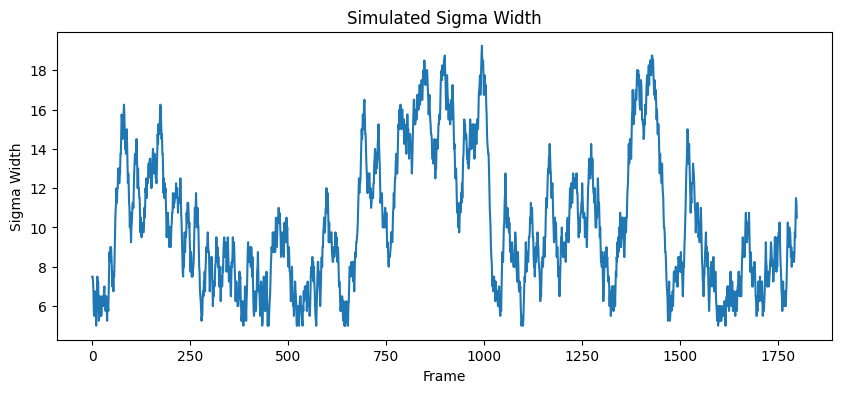

In [16]:
from matplotlib import pyplot as plt
import numpy as np

expectedFrameRate = 60
toleranceTrialN = 600

def generateWalkofSigmaDifficulty(meanSigma=15, velocity_std=1, duration=20, minSigma=5, maxSigma=35):
    num_frames = int(duration * expectedFrameRate) + toleranceTrialN
    increments = np.array([-1, -0.75, -0.5, -0.25, 0,0.25, 0.5, 0.75, 1])
    print(increments.std())
    sigma_width = np.zeros(num_frames)
    sigma_width[0] = meanSigma  # Start from the meanSigma

    for i in range(1, num_frames):
        # Filter increments to only those that do not push sigma_width out of bounds
        valid_increments = increments[(sigma_width[i-1] + increments >= minSigma) & (sigma_width[i-1] + increments <= maxSigma)]
        if valid_increments.size == 0:
            # If no valid increments, maintain current position
            sigma_width[i] = sigma_width[i-1]
        else:
            # Randomly choose from the valid increments
            sigma_width[i] = sigma_width[i-1] + np.random.choice(valid_increments)
    return sigma_width

# Generate data
allSigmaWalks = generateWalkofSigmaDifficulty(meanSigma=7.5, velocity_std=1, duration=20, minSigma=5, maxSigma=35)
print(allSigmaWalks.mean())
# Plot the first 1000 data points
plt.figure(figsize=(10, 4))
plt.plot(allSigmaWalks)
plt.title('Simulated Sigma Width')
plt.xlabel('Frame')
plt.ylabel('Sigma Width')
plt.show()
